# Model proto

This is a rough prototype of our RL solution

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
import time
import sys
import os

if '..' not in sys.path: sys.path.append('..')

from src.utils.common import *
from src.utils.plot_utils import *
from src.dnd.actions import *
from src.dnd.units import *
from src.dnd.game_utils import *
from src.dnd.game_board import DnDBoard, GameState
from src.agent.agent import DnDAgent, IdleDnDAgent, RandomAgent
from src.agent.deep_q_network import *
from src.agent.agent_utils import get_legal_action_resolver, get_states, agents_play_loop
from src.dnd.game_configs import *

In [3]:
seed_everything(1234, deterministic_cudnn=True)

## Sample agent game

In [4]:
def ava_reward_trivial(game, data_agent, data_enemy):
    game_state, unit, player_id, move_legal, action_legal, updates = data_agent

    units_removed = updates['units_removed']
    reward = 0
    # reward for removing enemy units, 1 for each unit
    reward += len([x for x in units_removed if x[1] != player_id]) * 1
    # reward for winning
    if len(game.players_to_units[player_id]) == len(game.units):
        reward += 10
    #if data_enemy is not None and data_enemy[0] == GameState.WIN:
    #    reward -= 10
    # penalty for losing (on your own turn ??)
    if len(game.players_to_units[player_id]) == 0:
        reward = -100
    
    return reward

In [5]:
def train_loop_ava_simple(agent: DnDAgent,
                          enemy: DnDAgent,
                          game: DnDBoard, 
                          reward_fn: callable,
                          iter_limit: int=10000) -> tuple[int, bool]:
    last_state, last_action, last_turn_info = None, None, None
    
    for iter_count in range(iter_limit):
        if game.current_player_id == 0: # agent turn
            last_state, last_action, new_coords, action = get_states(game, agent)
            last_turn_info = game.take_turn(new_coords, action, skip_illegal=True)
            game_over = last_turn_info[0] != GameState.PLAYING

            if game.current_player_id == 0: # if the next move is agent's move again, memorize current transition
                reward = reward_fn(game, last_turn_info, None)
                new_state = game.observe_board()
                agent.memorize(last_state, last_action, reward, new_state, game_over)
                agent.learn()
            
            if game_over:
                return iter_count + 1, last_turn_info[0] == GameState.WIN

        else: # enemy turn
            _, _, new_coords, action = get_states(game, enemy)
            enemy_turn_info = game.take_turn(new_coords, action, skip_illegal=True)
            game_over = enemy_turn_info[0] != GameState.PLAYING

            if game.current_player_id == 0 and last_state is not None: # if the next move is agent's, memorize the transition
                new_state = game.observe_board()
                reward = reward_fn(game, last_turn_info, enemy_turn_info)
                agent.memorize(last_state, last_action, reward, new_state, game_over)
                agent.learn()

            if game_over:
                return iter_count + 1, enemy_turn_info[0] == GameState.LOSE

    raise RuntimeError('Iteration limit exceeded')

In [6]:
board_size, game_config = get_2v2_1_config()

agent = DnDAgent(board_shape=board_size, in_channels=8, out_actions=2, 
    lr=1e-3,
    epsilon=0.9, 
    min_epsilon=0.01,
    epsilon_delta=1e-5, 
    epsilon_strategy='exp',
    gamma=0.9,
    batch_size=32,
    dual_learning=True, 
    replace_model_interval=10000,
    memory_capacity=100000,
    random_action_resolver=get_legal_action_resolver(board_size),
    model_class=DnDEvalModelRT5
)

train_loop = train_loop_ava_simple
reward_policy = ava_reward_trivial

In [7]:
ref_agent_paths = [
    '../rnd/2v2-1/gen3/checkpoints/agent-13.9i-20.0k'
]

ref_agents = [(DnDAgent.load_agent(x, strip=True, epsilon=0), x.split('/')[-3] + '/' + x.split('/')[-1]) for x in ref_agent_paths]
#ref_agents.append((IdleDnDAgent(), 'Idle agent'))
#ref_agents.append((RandomAgent(board_size, 2, action_resolver=get_legal_action_resolver(board_size)), 'Random agent'))
ref_agents.append((agent, 'Self play'))

In [8]:
# set to None to disable report / figures export
output_path = '../rnd/2v2-1/'
generation_name = 'gen14'
gen_header = \
'''# Residual tower-5 model (AVA: gen7 against gen3 + partial self play)

'''

In [9]:
iters, eps, checkpoints, reps, wins = [], [], [], [], []
mag1s, mag2s = [], []

did_replace = [ False ]
def on_replace():
    global did_replace
    did_replace[0] = True
    
agent.on_replace = on_replace

if output_path is not None:
    gen_path = os.path.join(output_path, generation_name)
    os.makedirs(gen_path)
else: gen_path = '..' # so that checkpoints still work

In [10]:
def plot_ava_training_history(wins, ref_agents, 
                              eps=None, 
                              checkpoints=None,
                              vlines=None,
                              xlim=None, 
                              #ylim=None, 
                              figsize=(11, 6), 
                              show=True):
    plt.figure(figsize=figsize)
    plt.title('Winrate')
    plt.xlabel('Game')
    plt.ylabel('Winrate')
    if xlim is None: xlim = [None, None]
    else: xlim = list(xlim)
    if xlim[0] is None: xlim[0] = 0
    if xlim[1] is None: xlim[1] = len(wins)
    plt.xlim(xlim)
    plt.ylim(-0.4, 100.4)

    ax: plt.Axes = plt.gca()

    agent_cnt = len(ref_agents)

    per_agent_wins = [(list(range(x, len(wins), agent_cnt)), wins[x::agent_cnt]) for x in range(agent_cnt)]
    
    for (xs, ys), (_, name) in zip(per_agent_wins, ref_agents):
        if len(ys) == 0: continue
        n = 30
        win_conv = 100 * np.convolve(ys, np.ones(n) / n, mode='valid')
        ax.plot(np.linspace(n // 2, len(wins) - n // 2, len(win_conv)), win_conv, lw=1)

        n = 300
        win_conv = 100 * np.convolve(ys, np.ones(n) / n, mode='valid')
        ax.plot(np.linspace(n // 2, len(wins) - n // 2, len(win_conv)), win_conv, lw=3, label=name)

    ax.axhline(50, color='k', lw=2, linestyle='--')
    ax.grid()

    artists, labels = ax.get_legend_handles_labels()
    
    ax2 = None
    if eps is not None:
        ax2 = plt.twinx()
        ax2.plot(eps, color='red', label='Epsilon')

        for x, y in zip((artists, labels), ax2.get_legend_handles_labels()): x += y

    if vlines is None: vlines = []
    vlines = vlines.copy()
    if len(vlines) > 0 and not hasattr(vlines[0], '__len__'): vlines = [vlines]
    if checkpoints is not None: vlines.append({'data': checkpoints, 'c': 'k', 'alpha': 0.6, 'lw': 1.5, 'linestyle': '--'})

    for vline in vlines:
        if isinstance(vline, dict):
            points = vline.pop('data')
            kwargs = vline
        else:
            points = vline
            kwargs = { 'c': 'red', 'lw': 1, 'linestyle': '--', 'alpha': 0.8}
            
        for point in points:
            ax.axvline(point, **kwargs)

    ax.legend(artists, labels, loc='upper right')

    if show: plt.show()
    else: return (ax, ax2) if ax2 is not None else ax

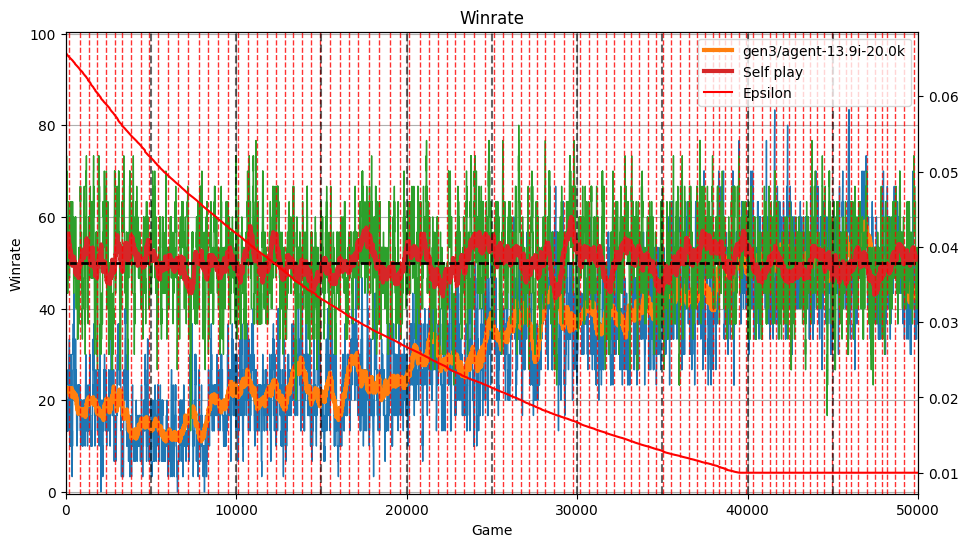

Training:   0%|          | 0/250000 [00:00<?, ?it/s, mag1=59.5, mag2=32.8]

PicklingError: Can't pickle <function DnDBoard.__passthrough_reward_head at 0x0000021BC01F0B80>: attribute lookup DnDBoard.__passthrough_reward_head on src.dnd.game_board failed

In [21]:
games = 250000
checkpoint_each = 5000
last_update = -1e9

last_checkpoint = checkpoints[-1] if len(checkpoints) > 0 else 0
with tqdm(range(games), desc='Training', smoothing=0.1) as pbar:
    for i in pbar:
        iter_i = len(iters)
        ref_agent = ref_agents[iter_i % len(ref_agents)][0]
        game = generate_balanced_game(board_size, game_config)
        outputs = agent.predict(game.observe_board())
        metric = np.mean(np.abs(outputs), axis=(1, 2))
        iter_count, win = train_loop(agent, ref_agent, game, reward_policy, iter_limit=100000)
        iters.append(iter_count)
        wins.append(win)
        eps.append(agent.epsilon)
        mag1s.append(metric[0])
        mag2s.append(metric[1])
        pbar.set_postfix({'mag1': metric[0], 'mag2': metric[1]})

        ctime = time.time()
        if ctime - last_update > 30:
            clear_output(wait=True)
            plot_ava_training_history(wins, ref_agents, eps, checkpoints, vlines=reps)
            display(pbar.container)
            last_update = ctime

        if iter_i - last_checkpoint >= checkpoint_each:
            last_checkpoint = iter_i
            checkpoints.append(iter_i)
            agent.save_agent(os.path.join(gen_path, f'checkpoints/agent-{iter_i / 1000:0.1f}k'))

        if did_replace[0]:
            did_replace[0] = False
            reps.append(iter_i)
            # agent.replace_model_interval += replace_interval_delta

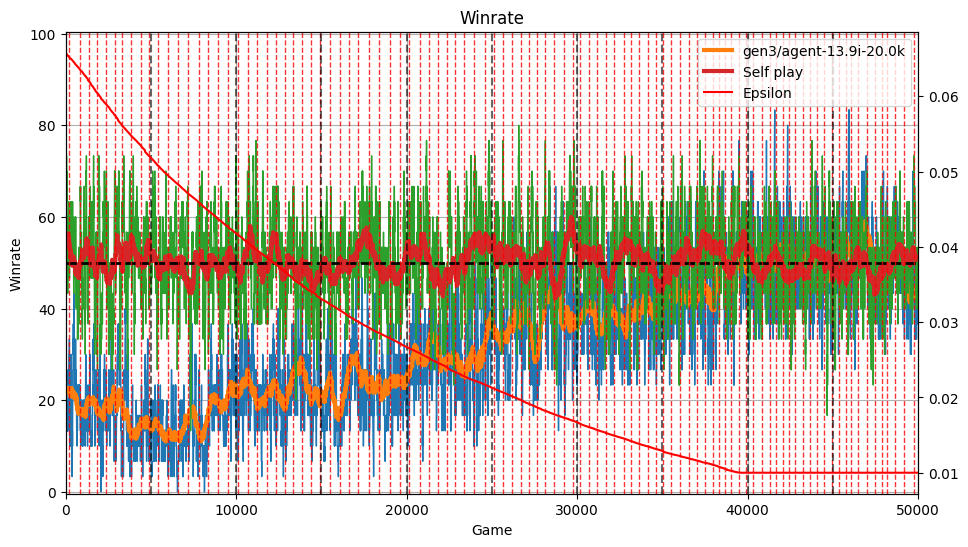

In [12]:
plot_ava_training_history(wins, ref_agents, eps, checkpoints, vlines=reps, show=False)
if output_path is not None:
    plt.savefig(os.path.join(gen_path, 'winrate.png'), bbox_inches='tight')
plt.show()

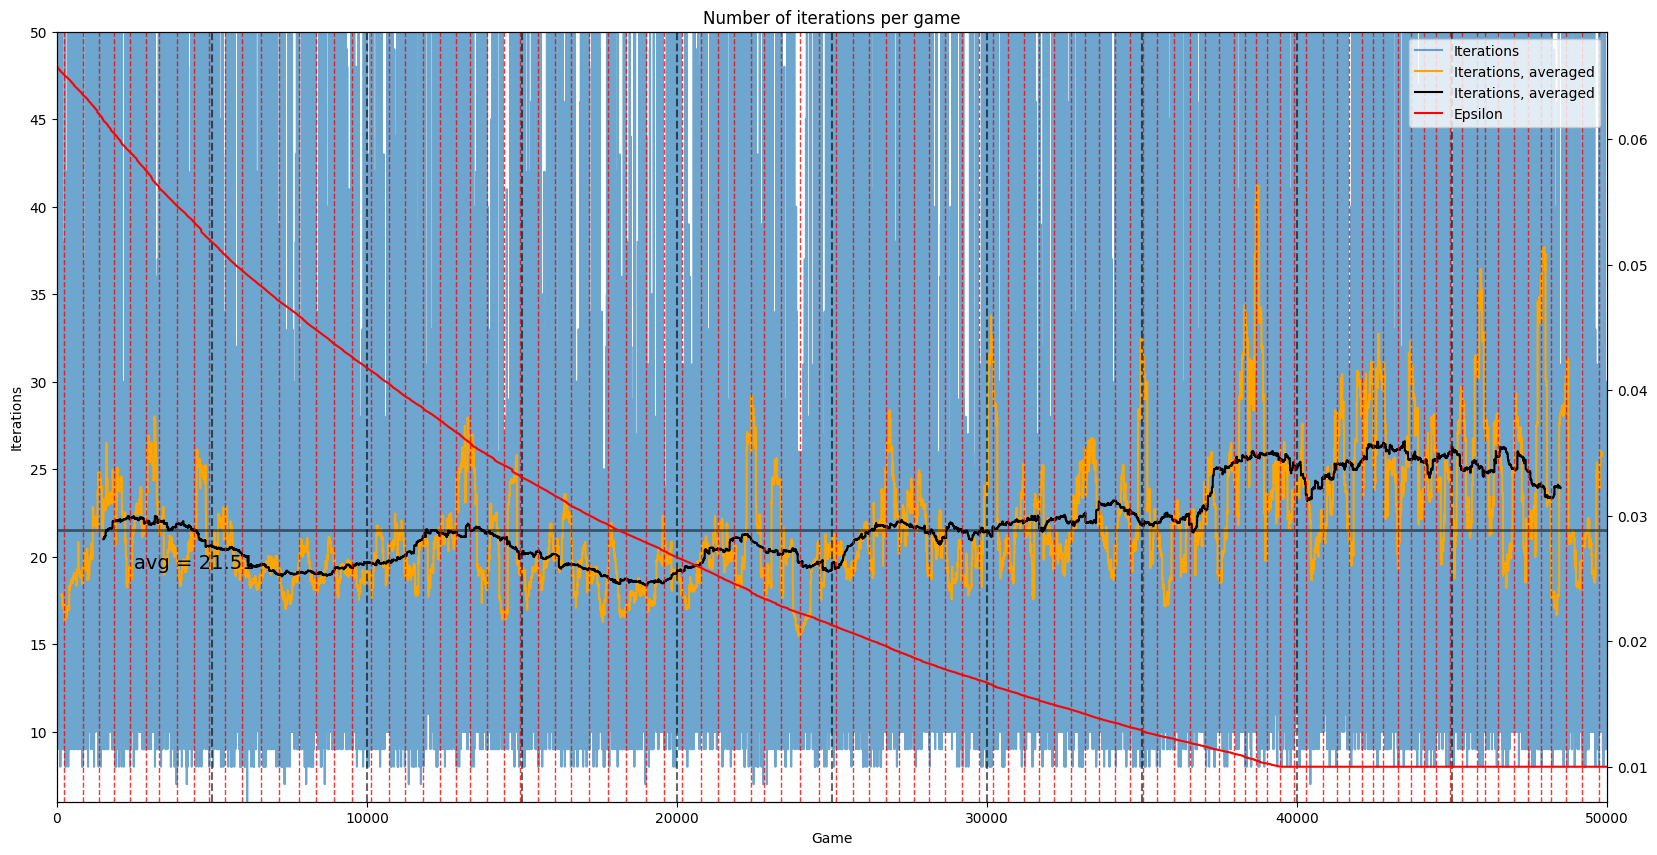

In [13]:
plot_training_history(iters, eps, checkpoints, vlines=reps, ylim=50, figsize=(20, 10), show=False)
if output_path is not None:
    plt.savefig(os.path.join(gen_path, 'training.png'), bbox_inches='tight')
plt.show()

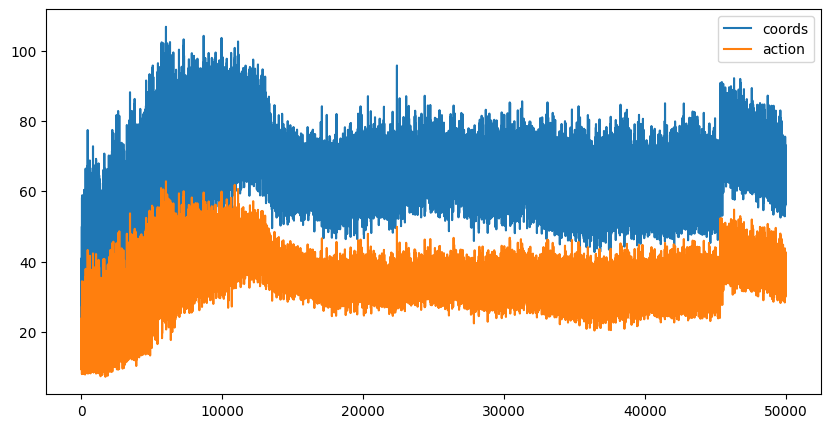

Total number of iterations: 1090720


In [14]:
plt.figure(figsize=(10, 5))
plt.plot(mag1s, label='coords')
plt.plot(mag2s, label='action')
#plt.yscale('log')
plt.legend()
if output_path is not None:
    plt.savefig(os.path.join(gen_path, 'magnitude.png'), bbox_inches='tight')
plt.show()
print(f'Total number of iterations: {np.sum(iters)}')

In [15]:
if output_path is not None:
    with open(os.path.join(gen_path, 'report.md'), 'w') as report:
        avg = np.mean(iters[-1000:])
        total = np.sum(iters)
        perf = 1e9 / (avg * total)
        report.write(
f'''{gen_header}
# Results
![image](winrate.png "")

![image](training.png "")

* Average iteration count after {games / 1000:0.1f}k games: {avg:0.2f}
* Total iterations performed: {total}
* Relative training performance: {perf:0.2f}
> 1e9 / (total_iter * avg_iter)

## Model's outputs magnitude history:

![magnitudes](magnitude.png "")

# Configuration

```python


games = {games}
```
''')

In [16]:
print(f'Shortest game: {np.min(iters)}')
print(f'Longest game: {np.max(iters)}')
print(f'Number of shortest games: {np.sum(np.array(iters) == np.min(iters))}')

Shortest game: 6
Longest game: 2866
Number of shortest games: 1


In [17]:
game, color_map = decorate_game(generate_balanced_game(board_size, game_config))

agents_play_loop(agent, agent, game, color_map, reset_epsilon=True, delay=1)

Iteration: 14
Turn made by player #0: `Ally archer`:
	Unit moves: (0, 6) -> (6, 6);
	And takes aciton `Sword attack` with attributes: {'source_unit': 'Ally archer', 'target_unit': 'Enemy archer'}

Units alive: 1
Players: 2:
	Player #0 (1 units): `Ally archer (25 HP)`,   
	Player #1 (0 units):   
	
    0 1 2 3 4 5 6 7
 0             ██   0 
 1                  1 
 2                  2 
 3                  3 
 4                  4 
 5                  5 
 6                  6 
 7                  7 
    0 1 2 3 4 5 6 7

Next move is by player #0: `Ally archer`

Game over in 14 iterations. Winner: player #1


(14, 0)

# Visualization

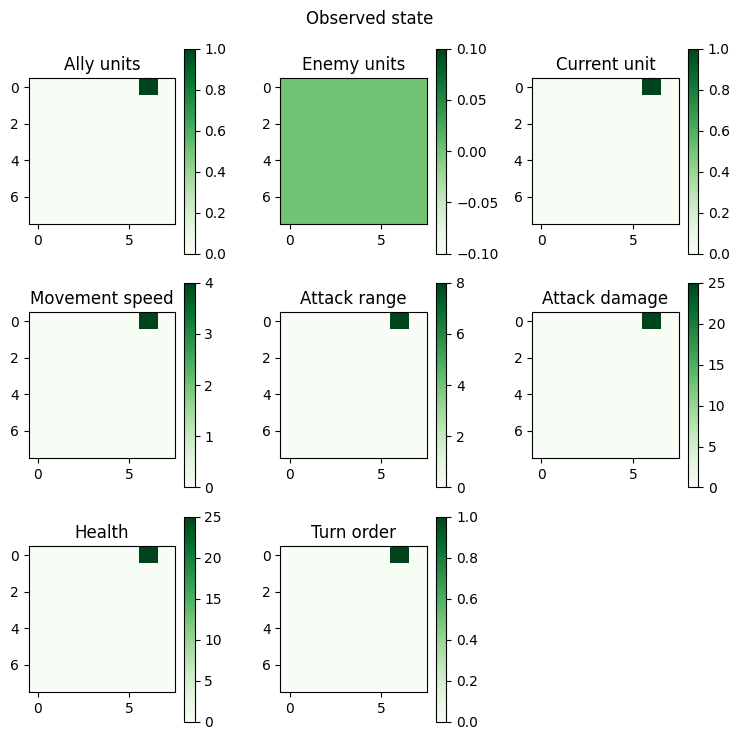

In [18]:
state = game.observe_board()
plot_featuremaps(
    state, 
    title='Observed state', 
    fm_names=game.CHANNEL_NAMES,
    vmin = -3,
    vmax = 3,
    separate_cbars=True,
    cmap='Greens'
)

In [19]:
game, color_map = decorate_game(generate_balanced_game(board_size, game_config))
agent.game = game
print_game(game, color_map)

Units alive: 4
Players: 2:
	Player #0 (2 units): `Ally soldier (100 HP)`, `Ally archer (50 HP)`  
	Player #1 (2 units): `Enemy soldier (100 HP)`, `Enemy archer (50 HP)`  
	
    0 1 2 3 4 5 6 7
 0                  0 
 1                  1 
 2 ██               2 
 3                  3 
 4 ██        ██     4 
 5                  5 
 6         ██       6 
 7                  7 
    0 1 2 3 4 5 6 7

Next move is by player #0: `Ally archer`


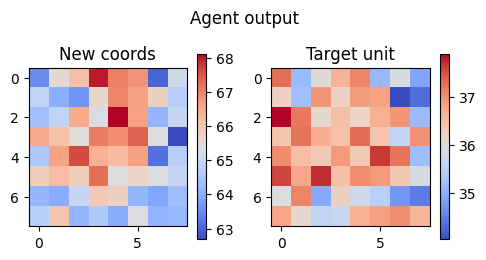

(array([2, 2], dtype=int64), array([4, 0], dtype=int64))


In [20]:
state = game.observe_board()
output = agent.predict(state)

plot_featuremaps(
    output, 
    title='Agent output', 
    fm_names=['New coords', 'Target unit'],
    separate_cbars=True
)

print(agent.choose_action_vector(state))